In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pickle as pkl
import keras.layers as layers
import keras.models as models
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf

np.random.seed(101)

In [ ]:
def model_build(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.Bidirectional(layers.LSTM(100, return_sequences=True), merge_mode='ave')(inp)
    x = layers.TimeDistributed(layers.Dense(256, activation='relu'))(x)
    x = layers.TimeDistributed(layers.Dense(256, activation='relu'))(x)
    x = layers.TimeDistributed(layers.Dense(256, activation='relu'))(x)
    out = layers.TimeDistributed(layers.Dense(1, activation='relu'))(x)
    model = models.Model(inputs=[inp], outputs=[out], name='Bidirectional LSTM')
    model.compile(optimizer='adam', loss=tf.losses.huber_loss, metrics=['mae'])
    model.summary()
    return model

In [3]:
def data_create(time_steps, num_features, df):
    x = []
    y = []
    for i in range(df.shape[0]-time_steps-1):
        x.append(list(df.values[i:i+time_steps]))
        y.append(list(df.values[i+1:i+time_steps+1]))
    x = np.array(x)
    y = np.array(y)
    print(x.shape, y.shape)
    return x,y      

In [4]:
time_steps = 7
features = 1
df = pd.DataFrame(pd.read_csv("PopcornSmallProphetInputDF.csv")['y'])
x,y = data_create(time_steps,features,df)

(932, 7, 1) (932, 7, 1)


In [5]:
train_split = int(0.7*x.shape[0])
x_train, x_test, y_train, y_test = x[:train_split], x[train_split:], y[:train_split], y[train_split:]
model = model_build(x.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7, 1)              0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 7, 100)            81600     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 256)            25856     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 7, 256)            65792     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 7, 256)            65792     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 7, 1)              257       
Total params: 239,297
Trainable params: 239,297
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

Train on 652 samples, validate on 280 samples
Epoch 1/100
652/652 [==============================] - 3s - loss: 410.6933 - mean_absolute_error: 411.1933 - val_loss: 261.1976 - val_mean_absolute_error: 261.6976
Epoch 2/100
652/652 [==============================] - 0s - loss: 244.9814 - mean_absolute_error: 245.4813 - val_loss: 193.8244 - val_mean_absolute_error: 194.3237
Epoch 3/100
652/652 [==============================] - 0s - loss: 119.1103 - mean_absolute_error: 119.6094 - val_loss: 103.2957 - val_mean_absolute_error: 103.7948
Epoch 4/100
652/652 [==============================] - 0s - loss: 107.0363 - mean_absolute_error: 107.5359 - val_loss: 110.2228 - val_mean_absolute_error: 110.7219
Epoch 5/100
652/652 [==============================] - 0s - loss: 105.8217 - mean_absolute_error: 106.3208 - val_loss: 110.8026 - val_mean_absolute_error: 111.3018
Epoch 6/100
652/652 [==============================] - 0s - loss: 99.7869 - mean_absolute_error: 100.2857 - val_loss: 101.4184 - val_m

In [7]:
y_pred = model.predict(x_test)

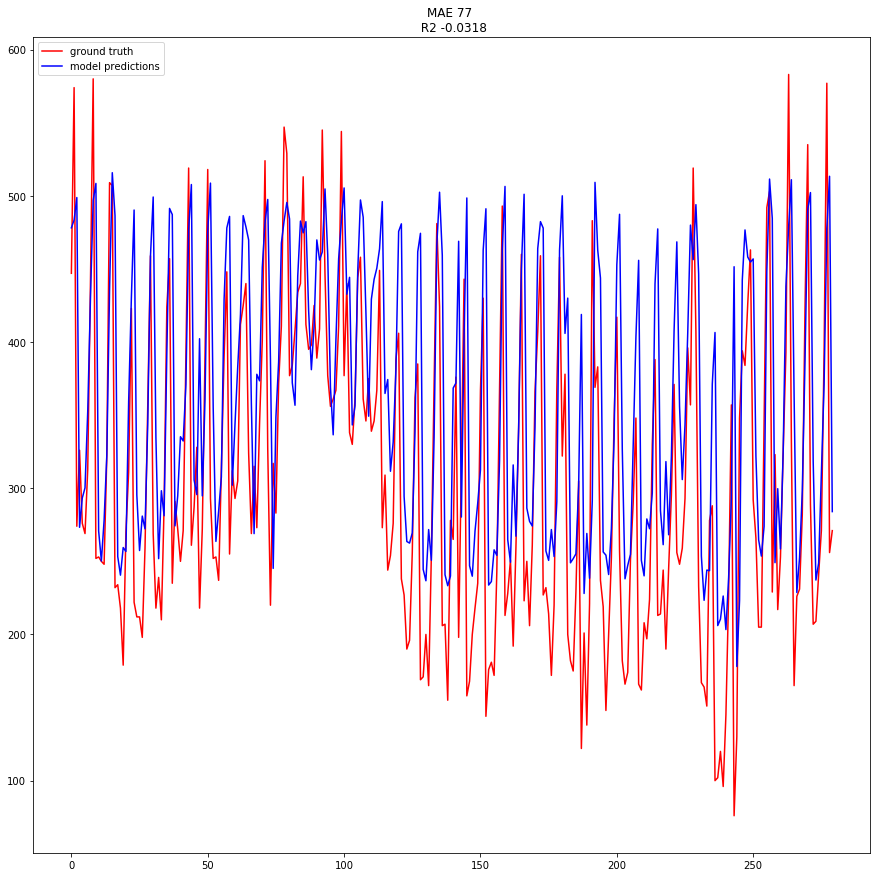

In [10]:
pred = pd.Series(y_pred[:,-1].flatten())
test = pd.Series(y_test[:,-1].flatten())

from sklearn.metrics import mean_absolute_error, r2_score
plt.figure(figsize=(15,15))
plt.title("MAE %.f \n R2 %.4f"%(mean_absolute_error(test,pred), r2_score(test,pred)))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()